Let us illustrate how we may use `calibrated_explanations` to generate explanations from a classifier trained on a dataset from
[www.openml.org](https://www.openml.org), which we first split into a
training and a test set using `train_test_split` from
[sklearn](https://scikit-learn.org), and then further split the
training set into a proper training set and a calibration set:

In [46]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

dataset = fetch_openml(name="qsar-biodeg")

X = dataset.data.values.astype(float)
y = dataset.target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2,stratify=y)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)


We now fit a model on our data. 

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1)

rf.fit(X_prop_train, y_prop_train)

RandomForestClassifier(n_jobs=-1)

Let us explain a test instance using the `calibrated_explanations`.

In [49]:
from calibrated_explanations import CalibratedExplainer

explainer = CalibratedExplainer(rf, X_cal, y_cal)

factual_explanations = explainer(X_test)

Once we have the explanations, we can plot them using `plot_regular` or `plot_uncertainty`

In [ ]:
factual_explanations.plot_regular()
factual_explanations.plot_uncertainty()

factual_explanations.add_conjunctive_factual_rules().plot_regular()
factual_explanations.remove_conjunctive_rules().plot_regular()

An alternative to factual rules is to extract counterfactual rules. 
From version 0.0.8, `get_counterfactuals` can be called to get counterfactual rules with an appropriate discretizer automatically assigned. An alternative is to first change the discretizer to `entropy` (for classification) and then call the `CalibratedExplainer` object as above.  

In [41]:
counterfactual_explanations = explainer.get_counterfactuals(X_test)

# or alternatively
explainer.set_discretizer('entropy')
counterfactual_explanations = explainer(X_test)

counterfactuals are visualized using the `plot_counterfactuals`. Adding or removing conjunctions is done as before. 

In [ ]:
counterfactual_explanations.plot_counterfactuals()
counterfactual_explanations.add_conjunctive_counterfactual_rules().plot_counterfactuals()
counterfactual_explanations.remove_counterfactual_rules().plot_counterfactuals()

Extracting explanations for regression is very similar to how it is done for classification. First we load and divide the dataset.   

In [52]:
dataset = fetch_openml(name="house_sales", version=3)

X = dataset.data.values.astype(float)
y = dataset.target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

Let us now fit a `RandomForestRegressor` from
[sklearn](https://scikit-learn.org) to the proper training
set:

In [53]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_prop_train, y_prop_train)

RandomForestRegressor()

Define a `CalibratedExplainer` object using the new model and data. The `mode` parameter must be explicitly set to regression. By default, explanations based on a two-sided interval with 90% confidence are provided. 

In [55]:
explainer = CalibratedExplainer(rf, X_cal, y_cal, mode='regression')

# from version 0.0.8, the following is recommended
factual_explanations = explainer.get_factuals(X_test)

# or alternatively
factual_explanations = explainer(X_test)

Regression also offer both regular and uncertainty plots for factual explanations with or without conjunctive rules, in almost exactly the same way as for classification. 

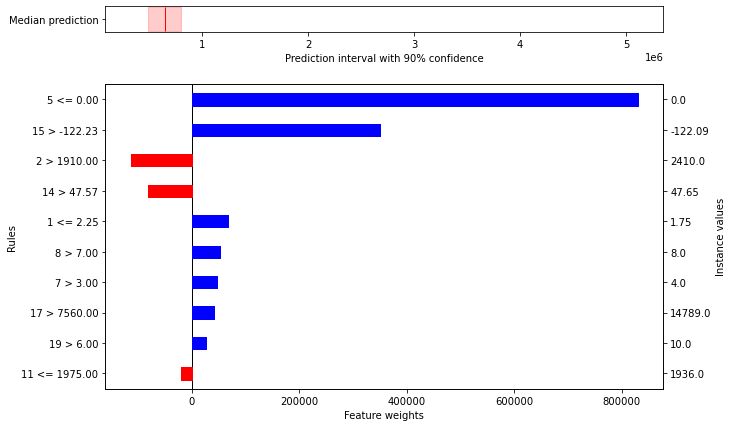

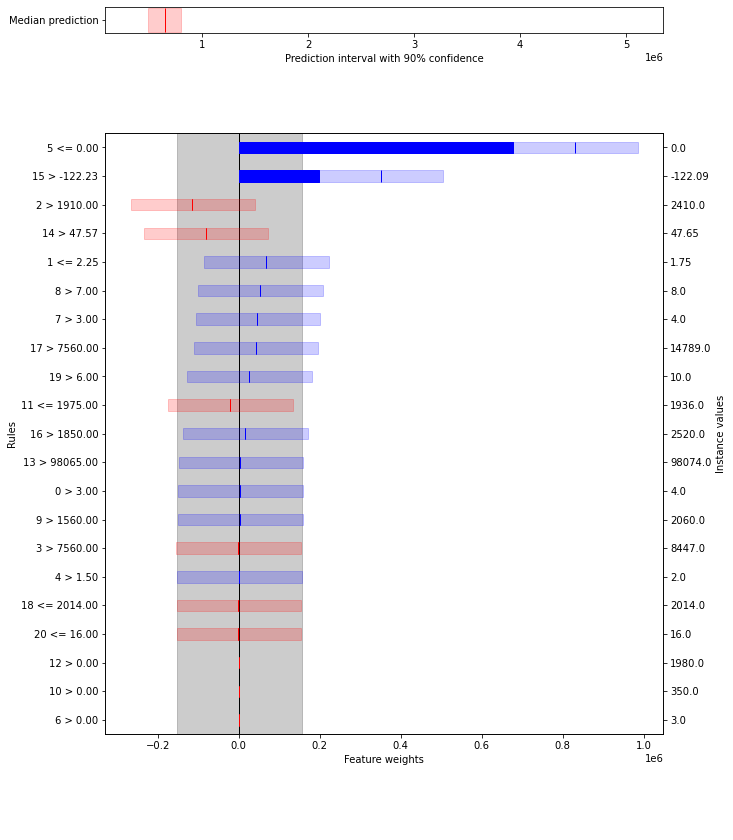

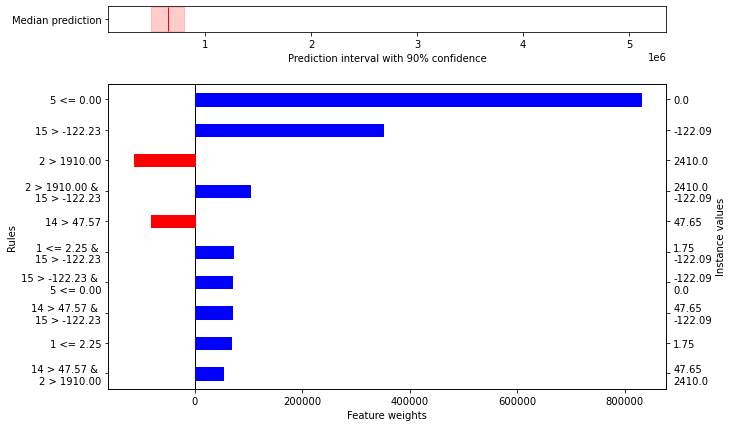

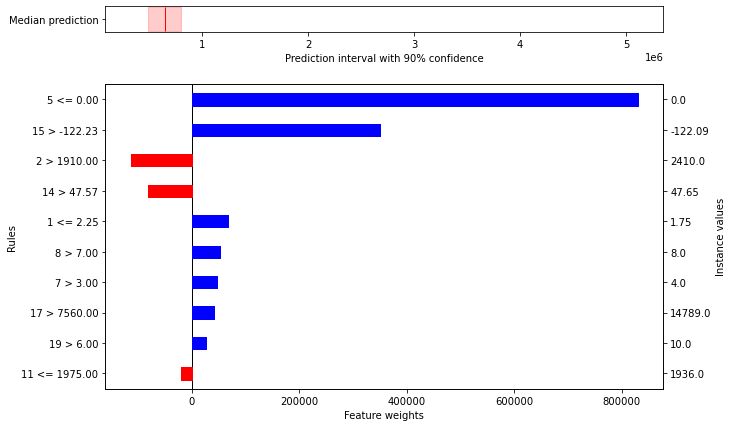

In [56]:
factual_explanations.plot_regular()
factual_explanations.plot_uncertainty()

factual_explanations.add_conjunctive_factual_rules().plot_regular()
factual_explanations.remove_conjunctive_rules().plot_regular()

From version 0.0.8, the `get_counterfactuals` will work exactly the same as for classification. Otherwise, the discretizer must be set explicitly and the 'decile' discretizer is recommended. Counterfactual plots work as for classification.

counterfactual_explanations = explainer.get_counterfactuals(X_test)

# or alternatively
explainer.set_discretizer('decile')
counterfactual_explanations = explainer(X_test)

counterfactual_explanations.plot_counterfactuals()
counterfactual_explanations.add_conjunctive_counterfactual_rules().plot_counterfactuals()
counterfactual_explanations.remove_counterfactual_rules().plot_counterfactuals()

Regression offers many more options but to learn more about them, see the [demo_regression](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_regression.ipynb) or the [demo_probabilistic_regression](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_probabilistic_regression.ipynb) notebooks.